# Importation des packages

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import normal, uniform
from scipy.stats import multivariate_normal 

# Définition de notre vrai modèle

In [3]:
def true_model(a_0, a_1, noise_sigma, x):
    """
    On définit le vrai modèle générant les données et que l'on cherche à retrouver
    """
    return a_0 + a_1*x + normal(0, noise_sigma, len(x))

# Définition de la classe LinearBayes qui implémente la régression linéaire bayésienne et qui comprend une actualisation des paramètres et le tracé de graphiques décrivant les prédictions

In [4]:
class LinearBayes(object):
    """
    On crée une classe qui contient les paramètres de la prior et des posteriors et du bruit blanc
    On précède les array (format 1xd) par un a_, les vecteurs (format dx1) par un v_ et les matrices par un m_
    a_m0 représente la moyenne de la prior (1x2)
    m_S0 représente la matrice de covariance de la prior (2x2)
    beta représente la précision supposée connue du bruit (réel)     
    """
    def __init__(self, a_m0, m_S0, beta):
        self.prior = multivariate_normal(mean=a_m0, cov=m_S0)
        self.v_m0 = a_m0.reshape(a_m0.shape + (1,)) #reshape to column vector
        self.m_S0 = m_S0
        self.beta = beta
        self.v_mN = self.v_m0
        self.m_SN = self.m_S0
        self.posterior = self.prior
        
    def posterior_update(self, a_x, a_y):
        """
        On actualise les paramètres de la posterior étant donné les valeurs de (x_i,y_i)
        """
        v_y = a_y.reshape(a_y.shape + (1,))
        m_x = np.ones((len(a_x), 2))
        m_x[:, 1] = a_x
        self.m_SN = np.linalg.inv(np.linalg.inv(self.m_S0) + self.beta*m_x.T.dot(m_x))
        self.v_mN = self.m_SN.dot(np.linalg.inv(self.m_S0).dot(self.v_m0) + self.beta*m_x.T.dot(v_y))
        self.posterior = multivariate_normal(mean=self.v_mN.flatten(), cov=self.m_SN)

    def confidence_intervals(self, a_x, stdevs):
        """
        On définit les intervalles de confiance sur les graphiques qu'on va tracer en calculant la moyenne
        et les écarts-type pour une valeur donnée de x (a_x représente l'array des x_i et stdevs représente le 
        nombre d'écarts par rapport à la moyenne, par exemple stdevs = 1 calcule pour la borne sup et stdevs = -1 
        calcule pour la borne inf)
        """
        N = len(a_x)
        m_x = np.ones((len(a_x), 2))
        m_x[:, 1] = a_x
        m_x = m_x.T.reshape((2, 1, N))
        predictions = []
        for idx in range(N):
            x = m_x[:,:,idx]
            sig_sq_x = 1/self.beta + x.T.dot(self.m_SN.dot(x))
            mean_x = self.v_mN.T.dot(x)
            predictions.append((mean_x+stdevs*np.sqrt(sig_sq_x)).flatten())
        return np.concatenate(predictions)
    
    def distribution_plot(self, a_x, a_y, true_parms=[], N=0):
        """
        On trace la répartition de notre distribution de proba graphiquement sur l'espace des paramètres
        """
        pos = np.empty(a_x.shape + (2,))
        pos[:, :, 0] = a_x
        pos[:, :, 1] = a_y

        plt.contourf(a_x, a_y, self.posterior.pdf(pos), 20)
        plt.xlabel('$w_0$', fontsize=16)
        plt.ylabel('$w_1$', fontsize=16)
        plt.scatter(true_parms[0], true_parms[1], marker='+', c='black', s=60)
        plt.title('Distribution des paramètres pour %d donnée(s)' % N, fontsize=10)
    
    def predictive_plot(self, a_x, a_y, true_parms, samples=None, stdevs=None):
        """
        On trace les données avec bruit, la vraie droite et des droites prédites avec ou sans intervalles de confiance
        """
        plt.scatter(a_x, a_y, alpha=0.5)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.plot([-1, 1], true_model(true_parms[0], true_parms[1], 0, np.array([-1., 1.])), 'r')
        plt.title('Représentation graphique des données')
        
        if samples:
            weights = self.posterior.rvs(samples)
            for weight in weights: 
                plt.plot([-1, 1], true_model(weight[0], weight[1], 0, np.array([-1., 1.])), 'black')
                plt.title('Quelques droites prédites')
                
        if stdevs:
            a_xrange = np.linspace(-1, 1, 100)
            y_upper = self.confidence_intervals(a_xrange, stdevs)
            y_lower = self.confidence_intervals(a_xrange, -stdevs)
            plt.plot(a_xrange, y_upper, '+', c='green', linewidth=4.0)
            plt.plot(a_xrange, y_lower, '+', c='green', linewidth=4.0)
            plt.title('Quelques droites prédites avec intervalle de confiance')

# Génération des données

In [5]:
# On utilise les paramètres du livre de Bishop
a_0 = -0.3
a_1 = 0.5
noise_sigma = 0.2
beta = (1/noise_sigma)**2
# On génère 10 000 x_i depuis une uniforme sur [-1,1]
np.random.seed(20) 
x_i = uniform(-1, 1, 1000)
# On génère ensuite les y_i à partir des x_i et du bruit
y_i = true_model(a_0, a_1, noise_sigma, x_i)

# Définition du modèle

In [6]:
# On définit les paramètres de la prior et notre modèle
alpha = 2.0
v_m0 = np.array([0., 0.])
m_S0 = 1/alpha*np.identity(2)
Model = LinearBayes(v_m0, m_S0, beta)

# Représentation graphique des données

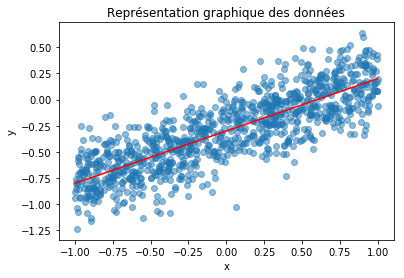

In [7]:
Model.predictive_plot(x_i, y_i, true_parms = [a_0, a_1])

# Représentation graphique de la prior

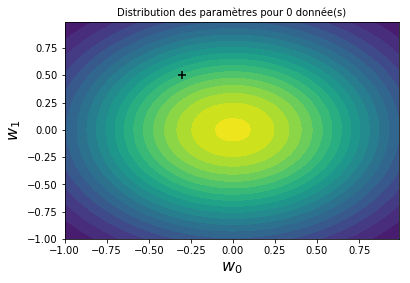

In [8]:
x, y = np.mgrid[-1:1:0.01, -1:1:0.01]
Model.distribution_plot(x, y, true_parms=[a_0, a_1], N=0)

# Etude de la prédiction pour une seule donnée

### Définition du nombre de données

In [9]:
N = 1

### Représentation de la compatibilité entre notre donnée et le modèle

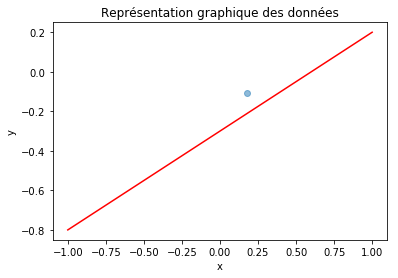

In [10]:
Model.predictive_plot(x_i[0:N], y_i[0:N], true_parms=[a_0, a_1])

### Représentation graphique de la posterior

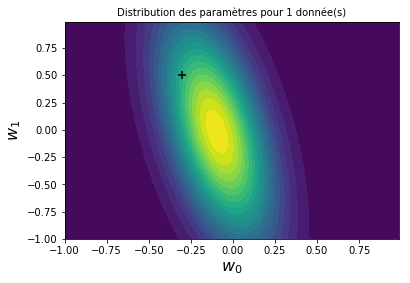

In [11]:
Model.posterior_update(x_i[0:N], y_i[0:N])
Model.distribution_plot(x, y, true_parms=[a_0, a_1], N=N)

### Modèle estimé à partir de la posterior

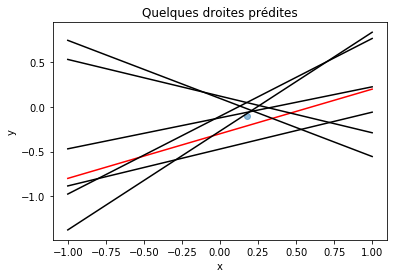

In [12]:
Model.predictive_plot(x_i[0:N], y_i[0:N], true_parms=[a_0, a_1], samples=6)

### Intervalles de confiance pour nos estimations de l'output en fonction de x et des paramètres

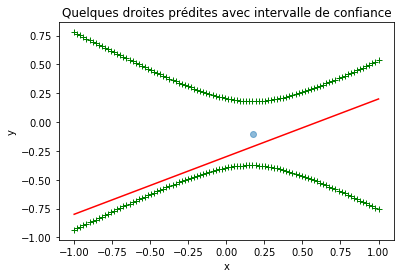

In [13]:
Model.predictive_plot(x_i[0:N], y_i[0:N], true_parms=[a_0, a_1], stdevs=1)

### Superposition des deux graphiques précédents

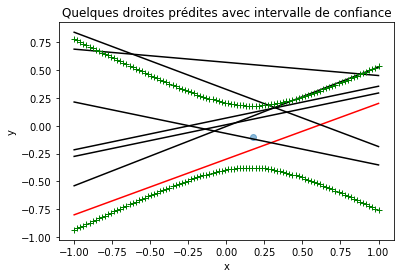

In [14]:
Model.predictive_plot(x_i[0:N], y_i[0:N], true_parms=[a_0, a_1], samples=6, stdevs=1)

# Etude de la prédiction avec 10 données

### Définition du nombre de données

In [15]:
N = 10

### Compatibilité entre nos données et le modèle

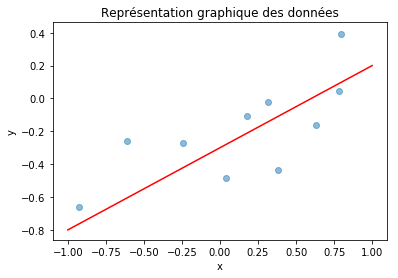

In [16]:
Model.predictive_plot(x_i[0:N], y_i[0:N], true_parms=[a_0, a_1])

### Représentation graphique de la posterior

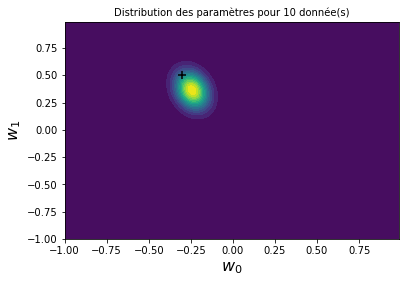

In [17]:
Model.posterior_update(x_i[0:N], y_i[0:N])
Model.distribution_plot(x, y, true_parms=[a_0, a_1], N=N)

### Modèle estimé à partir de la posterior

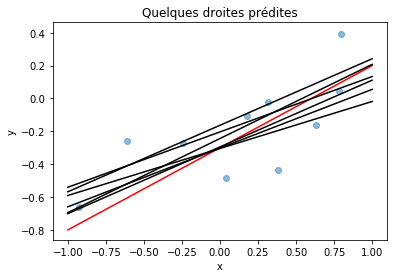

In [18]:
Model.predictive_plot(x_i[0:N], y_i[0:N], true_parms=[a_0, a_1], samples=6)

### Intervalles de confiance pour nos estimations de l'output en fonction de x et des paramètres

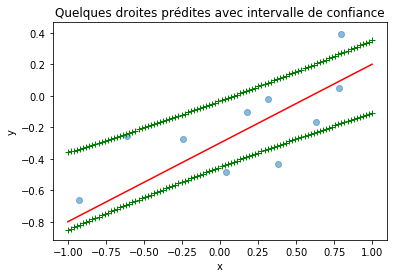

In [19]:
Model.predictive_plot(x_i[0:N], y_i[0:N], true_parms=[a_0, a_1], stdevs=1)

### Superposition des deux graphiques précédents

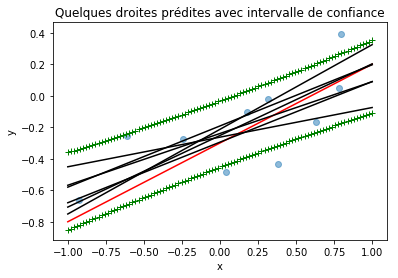

In [20]:
Model.predictive_plot(x_i[0:N], y_i[0:N], true_parms=[a_0, a_1], samples=6, stdevs=1)

# Etude de la prédiction avec 100 données

### Définition du nombre de données

In [21]:
N = 100

### Compatibilité entre nos données et le modèle

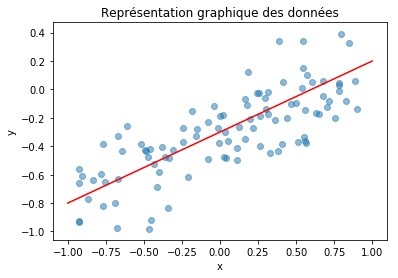

In [22]:
Model.predictive_plot(x_i[0:N], y_i[0:N], true_parms=[a_0, a_1])

### Représentation graphique de la posterior

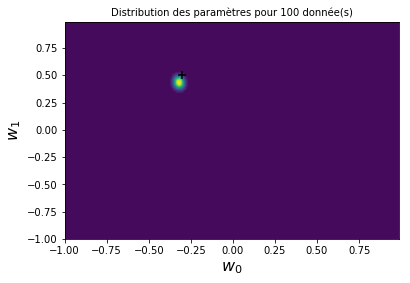

In [23]:
Model.posterior_update(x_i[0:N], y_i[0:N])
Model.distribution_plot(x, y, true_parms=[a_0, a_1], N=N)

### Modèle estimé à partir de la posterior

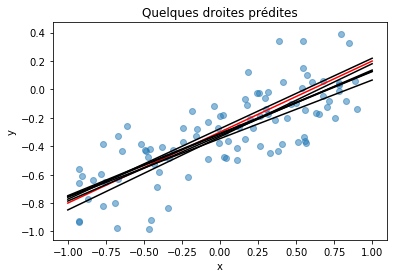

In [24]:
Model.predictive_plot(x_i[0:N], y_i[0:N], true_parms=[a_0, a_1], samples=6)

### Intervalles de confiance pour nos estimations de l'output en fonction de x et des paramètres

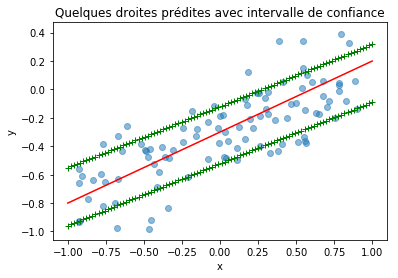

In [25]:
Model.predictive_plot(x_i[0:N], y_i[0:N], true_parms=[a_0, a_1], stdevs=1)

### Superposition des deux graphiques précédents

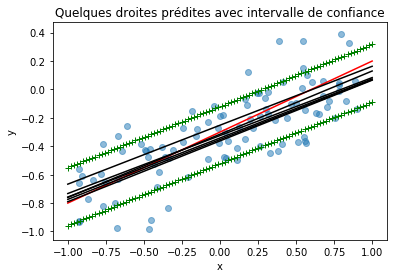

In [26]:
Model.predictive_plot(x_i[0:N], y_i[0:N], true_parms=[a_0, a_1], samples=6, stdevs=1)

# Etude de la prédiction avec 1000 données

### Définition du nombre de données

In [27]:
N = 1000

### Compatibilité entre nos données et le modèle

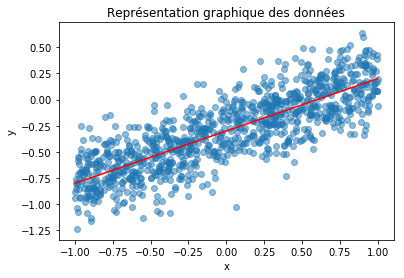

In [28]:
Model.predictive_plot(x_i[0:N], y_i[0:N], true_parms=[a_0, a_1])

### Représentation graphique de la posterior

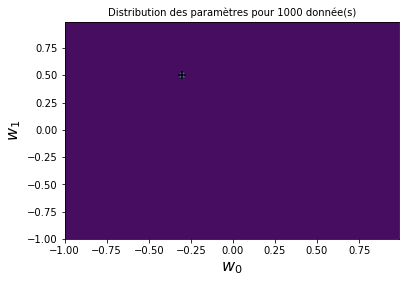

In [29]:
Model.posterior_update(x_i[0:N], y_i[0:N])
Model.distribution_plot(x, y, true_parms=[a_0, a_1], N=N)

### Modèle estimé à partir de la posterior

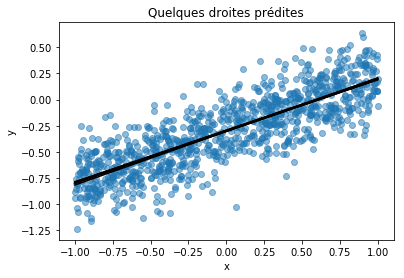

In [30]:
Model.predictive_plot(x_i[0:N], y_i[0:N], true_parms=[a_0, a_1], samples=6)

### Intervalles de confiance pour nos estimations de l'output en fonction de x et des paramètres

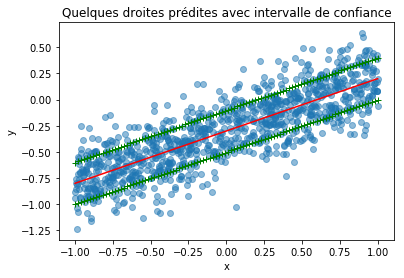

In [31]:
Model.predictive_plot(x_i[0:N], y_i[0:N], true_parms=[a_0, a_1], stdevs=1)

### Superposition des deux graphiques précédents

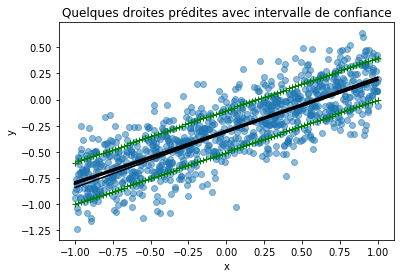

In [32]:
Model.predictive_plot(x_i[0:N], y_i[0:N], true_parms=[a_0, a_1], samples=6, stdevs=1)

# Comparaison régression linéaire bayésienne / fréquentiste

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_i, y_i, test_size=0.33, random_state=42)
X_train = X_train.reshape((670,1))
X_test = X_test.reshape((330,1))
y_train = y_train.reshape((670,1))
y_test = y_test.reshape((330,1))

from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

#Pour le bayesien :
#moyenne de la posterior : beta S_N X^TY
X_train2 = np.array([[1,i] for i in X_train])
m_N = beta*np.linalg.inv(np.mat(np.linalg.inv(m_S0))+beta * np.mat(X_train2.T)*np.mat(X_train2))*np.mat(X_train2.T)*np.mat(y_train)
def pred (param,x_i):
    return [float(param[0])+float(param[1])*float(x_i[i]) for i in range(len(x_i))]

y_pred2 = pred(m_N,X_test)
mean_squared_error(y_test, y_pred2)

0.041705661114639657